#### 受力变形comsol结果检测

使用手动求导，分析comsol计算结果是否满足给定方程。精度与取点密度有关

In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PINN.function import *

In [3]:
#E= 420*10**9 #杨氏模量
E=0.42
mu =0.14 #泊松比
G=E/2/(1+mu)  #剪切模量
alpha=4*10**-6 #线膨胀系数
beta=alpha *E /(1-2*mu) *10**6 #热应力系数

r1=0.135 #内径
r2=0.1695  #外径
h1=0.02  #高

fem=pd.read_csv('./data/3_P_1_u_200.txt',delimiter=r'\s+')
uu_run1=pd.read_csv('./data/run7-uu_array.txt',delimiter=r'\s+',header=None).to_numpy()
#fem=pd.read_csv('./data/sz1_10.txt',delimiter=r'\s+')
bound_optim=pd.read_csv('bound_optim.txt',delimiter=r'\s+',header=None).to_numpy()

In [4]:
print(beta*10)

23.33333333333333


In [5]:
def manual_diff_r(u,r,num=200):
    u=u.reshape((num,num)).T
    r=r.reshape((num,num)).T
    du_dr = np.zeros_like(u)
    for i in range(num): #行
        for j in range(num): #列
            if j==0:
                du_dr[i][j]=(u[i][j+1]-u[i][j])/(r[i][j+1]-r[i][j])
            elif j==num-1:
                du_dr[i][j]=(u[i][j]-u[i][j-1])/(r[i][j]-r[i][j-1])
            else:
                du_dr[i][j]=(u[i][j+1]-u[i][j-1])/(r[i][j+1]-r[i][j-1])


    return du_dr.flatten(order='F')

def manual_diff_z(u,z,num=200):
    u=u.reshape((num,num)).T
    z=z.reshape((num,num)).T
    du_dz = np.zeros_like(u)
    for i in range(num): #列
        for j in range(num): #行
            if j==0:
                du_dz[j][i]=(u[j+1][i]-u[j][i])/(z[j+1][i]-z[j][i])
            elif j==num-1:
                du_dz[j][i]=(u[j][i]-u[j-1][i])/(z[j][i]-z[j-1][i])
            else:
                du_dz[j][i]=(u[j+1][i]-u[j-1][i])/(z[j+1][i]-z[j-1][i])


    return du_dz.flatten(order='F')

In [6]:
num=200
u_f=fem['u'].values
r_f=fem['R'].values
w_f=fem['w'].values
z_f=fem['Z'].values
# u_f=uu_run1[:,0]
# w_f=uu_run1[:,1]
# r_f=fem['R'].values
# z_f=fem['Z'].values

r_norm, z_norm = torch.meshgrid(torch.linspace(0.0, 1.0, 200), torch.linspace(0.0, 1.0, 200))
r_norm=torch.flatten(r_norm).detach().numpy()
z_norm=torch.flatten(z_norm).detach().numpy()

sigma_rr_fem=fem['solid.sr'].values
sigma_theta_fem=fem['solid.sphi'].values
sigma_zz_fem=fem['solid.sz'].values
sigma_zr_fem=fem['solid.srz'].values

er=(sigma_rr_fem-mu*(sigma_theta_fem+sigma_zz_fem))/E
et=(sigma_theta_fem-mu*(sigma_rr_fem+sigma_zz_fem))/E
ez=(sigma_zz_fem-mu*(sigma_theta_fem+sigma_rr_fem))/E
ezr=sigma_zr_fem/G

du_dr=manual_diff_r(u_f,r_f,num)
dw_dz=manual_diff_z(w_f,z_f,num)
dw_dr=manual_diff_r(w_f,r_f,num)
du_dz=manual_diff_z(u_f,z_f,num)

du_dr_n=manual_diff_r(u_f,r_norm,num)
dw_dz_n=manual_diff_z(w_f,z_norm,num)
dw_dr_n=manual_diff_r(w_f,r_norm,num)
du_dz_n=manual_diff_z(u_f,z_norm,num)

sigma_rr=2*G * ((1-mu)/(1-2*mu)*du_dr + mu/(1-2*mu)*(u_f/r_f+dw_dz)) #*10**-12
sigma_theta=2*G * ((1-mu)/(1-2*mu)*u_f/r_f + mu/(1-2*mu)*(dw_dz+du_dr)) #*10**-12
sigma_zz=2*G * ((1-mu)/(1-2*mu)*dw_dz + mu/(1-2*mu)*(u_f/r_f+du_dr)) #*10**-12
sigma_zr=G*(dw_dr+du_dz)#*10**-12

sigma_rr_norm=2*G * ((1-mu)/(1-2*mu)*du_dr_n/(r2-r1) + mu/(1-2*mu)*(u_f/((r2-r1)*r_norm+r1)+dw_dz_n/h1)) *10**-12
sigma_theta_nrom=2*G * ((1-mu)/(1-2*mu)*u_f/((r2-r1)*r_norm+r1) + mu/(1-2*mu)*(dw_dz_n/h1+du_dr_n/(r2-r1))) *10**-12
sigma_zz_norm=2*G * ((1-mu)/(1-2*mu)*dw_dz_n/h1 + mu/(1-2*mu)*(u_f/((r2-r1)*r_norm+r1)+du_dr_n/(r2-r1))) *10**-12
sigma_zr_norm=G*(dw_dr_n/(r2-r1)+du_dz_n/h1)*10**-12

/Users/yst/anaconda3/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [7]:
#uu_run1=pd.read_csv('./data/run1-uu_array.txt',delimiter=r'\s+',header=None).to_numpy()

In [9]:
print(np.min(u_f))

12.467829079135203


In [56]:
print(np.shape(uu_run1[:,0]))

(40000,)


In [57]:
print(np.mean(abs(uu_run1[:,0]-u_f)/u_f))

8.395991376259644e-06


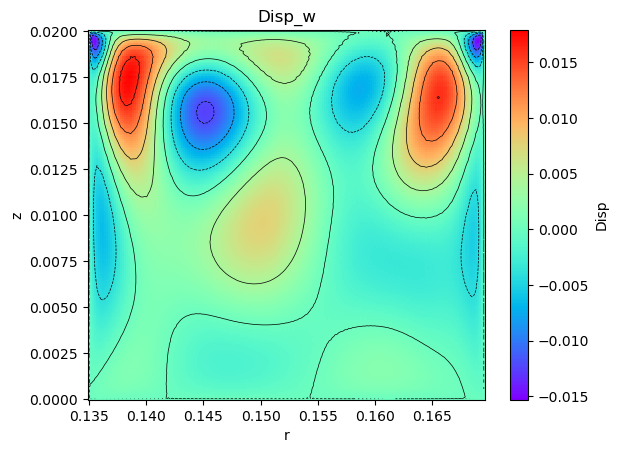

In [60]:
check_on_x=torch.linspace(r1, r2, 200)
check_on_y=torch.linspace(0.0, h1, 200)
xx, yy = np.meshgrid(check_on_x, check_on_y)
# 创建热力图
show_array=uu_run1[:,5]-sigma_zr_fem
heatmap=plt.pcolormesh(xx, yy,show_array.reshape(xx.shape).T,cmap='rainbow')  # cmap是颜色映射，你可以根据需要选择
contour_lines = plt.contour(xx, yy, show_array.reshape(xx.shape).T, 10,colors='black', linewidths=0.5)
# 添加颜色条
cbar=plt.colorbar(heatmap,label='Disp')
# 添加轴标签
plt.xlabel('r')
plt.ylabel('z')
plt.title('Disp_w')
plt.show()

In [12]:
dr=(r2-r1)/200
dz=h1/200

In [30]:
print(sum((sigma_rr_fem*er+sigma_zz_fem*ez+sigma_theta_fem*et+sigma_zr_fem*ezr)*r_f*dr*dz))

0.33133723503594403


In [28]:
sum(-2*r1*(-10)*u_f.reshape(200,200)[0]*dz)+sum(2*r2*(-1)*u_f.reshape(200,200)[-1]*dz)+sum(2*sigma_zz_fem.reshape(200,200)[:,-1]*w_f.reshape(200,200)[:,-1]*r_f.reshape(200,200)[:,-1]*dr)

0.6625716962211802

In [27]:
sum(2*sigma_zz_fem.reshape(200,200)[:,-1]*w_f.reshape(200,200)[:,-1]*r_f.reshape(200,200)[:,-1]*dr)

0.029654379095579244

In [26]:
z_left=z_f.reshape(200,200)
print(sigma_zz_fem.reshape(200,200)[:,-1])

[-9.99991248 -9.99870591 -9.99739939 -9.99326377 -9.98931738 -9.9825597
 -9.97610215 -9.96676917 -9.95777217 -9.94592989 -9.93440659 -9.92012162
 -9.90610461 -9.88944155 -9.87299003 -9.85400796 -9.83517915 -9.81393152
 -9.79278313 -9.76932594 -9.74591266 -9.72030287 -9.69468038 -9.66696881
 -9.6391986  -9.60943878 -9.57957436 -9.54782166 -9.51592149 -9.48222573
 -9.44834632 -9.41276282 -9.37696496 -9.3395451  -9.30188115 -9.26267828
 -9.2232044  -9.18227665 -9.14104911 -9.09844541 -9.05552022 -9.01130172
 -8.96673245 -8.92094796 -8.87479032 -8.82749359 -8.77980889 -8.73105371
 -8.68189229 -8.63173246 -8.58115589 -8.52964526 -8.47770958 -8.42489592
 -8.37165387 -8.31760013 -8.26310753 -8.2078614  -8.15217391 -8.09579568
 -8.03896909 -7.98151282 -7.92359613 -7.86511254 -7.80617135 -7.74671442
 -7.6867976  -7.6264213  -7.5655914  -7.50434973 -7.44265539 -7.38060235
 -7.31810628 -7.25529228 -7.19205019 -7.12853282 -7.06459673 -7.00042634
 -6.9358518  -6.87108982 -6.80593244 -6.74062547 -6.

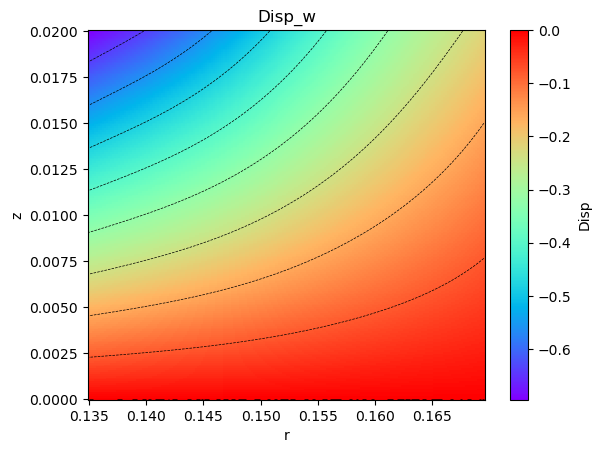

In [14]:
check_on_x=torch.linspace(r1, r2, 200)
check_on_y=torch.linspace(0.0, h1, 200)
xx, yy = np.meshgrid(check_on_x, check_on_y)
# 创建热力图
heatmap=plt.pcolormesh(xx, yy, w_f.reshape(xx.shape).T,cmap='rainbow')  # cmap是颜色映射，你可以根据需要选择
contour_lines = plt.contour(xx, yy, w_f.reshape(xx.shape).T, 10,colors='black', linewidths=0.5)
# 添加颜色条
cbar=plt.colorbar(heatmap,label='Disp')
# 添加轴标签
plt.xlabel('r')
plt.ylabel('z')
plt.title('Disp_w')
plt.show()

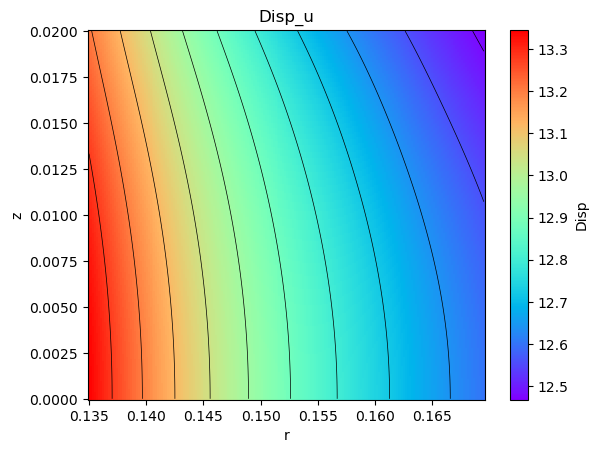

In [12]:
check_on_x=torch.linspace(r1, r2, 200)
check_on_y=torch.linspace(0.0, h1, 200)
xx, yy = np.meshgrid(check_on_x, check_on_y)
# 创建热力图
heatmap=plt.pcolormesh(xx, yy, u_f.reshape(xx.shape).T,cmap='rainbow')  # cmap是颜色映射，你可以根据需要选择
contour_lines = plt.contour(xx, yy, u_f.reshape(xx.shape).T, 10,colors='black', linewidths=0.5)
# 添加颜色条
cbar=plt.colorbar(heatmap,label='Disp')
# 添加轴标签
plt.xlabel('r')
plt.ylabel('z')
plt.title('Disp_u')
plt.show()

0.000531285015155261


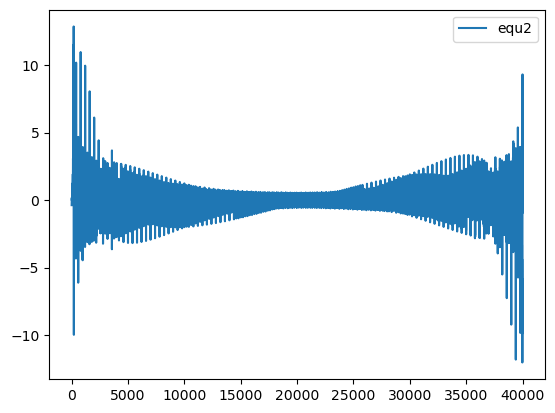

In [5]:
equ2=manual_diff_r(sigma_zr_fem,r_f,num)+manual_diff_z(sigma_zz_fem,z_f,num)+(sigma_zr_fem)/r_f
#equ2=manual_diff_z(sigma_zz_norm,z_norm,num)/h1+manual_diff_r(sigma_zr_norm,r_norm,num)/(r2-r1)+sigma_zr_norm/((r2-r1)*r_norm+r1)
print(np.mean(equ2))
plt.plot(equ2,label='equ2')
plt.legend()
plt.show()

-0.29663985093178563
[4.769438103461198, 4.716523028839835, 4.635081235206755, 4.648634983371495, 4.696980400604798, 4.661201856919784, 4.6010291713609295, 4.674052372172552, 4.713257556074586, 4.616165362434864, 4.647048166752137, 4.713872616236272, 4.6625484052818305, 4.622615890322093, 4.694630175548554, 4.715249065929288, 4.617502848288434, 4.674116288875484, 4.741011467910181, 4.661503727045342, 4.652687595123112, 4.726642520475084, 4.720735237858701, 4.625123722443605, 4.711327186509736, 4.777091664846586, 4.667428567197817, 4.691804142668845, 4.766798709413072, 4.729272439410911, 4.662534604492021, 4.757724322898797, 4.79861108667855, 4.6817127484064684, 4.740353715738035, 4.815686061536002, 4.742853287704436, 4.713474829368205, 4.811054209606012, 4.821926091133341, 4.705360125482809, 4.798748359495059, 4.8730317371856176, 4.761448065126368, 4.775452051440767, 4.87381121479565, 4.8479213714743805, 4.736394700720657, 4.868346971741581, 4.938222381198984, 4.785669340424268, 4.8489

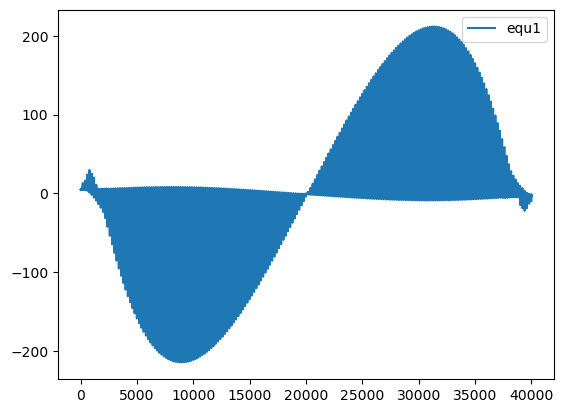

In [6]:
equ1=manual_diff_z(sigma_rr,z_f,num)+(sigma_rr-sigma_theta)/r_f
print(np.mean(equ1))
print(list(equ1))
plt.plot(equ1,label='equ1')
plt.legend()
plt.show()

0.7692371083380536
[63.78046465549214, 46.643240892264366, 29.536522302089764, 29.530739075791466, 29.50297047525253, 29.498951981387535, 29.505061302567597, 29.50415351289589, 29.501713902481207, 29.50588076191656, 29.505390287427765, 29.499364242422516, 29.50400109818375, 29.505788656478945, 29.50254145967991, 29.504069656639665, 29.50416672703868, 29.504842564110188, 29.497719111225756, 29.507451502107116, 29.50755431656856, 29.499642421447632, 29.50661756564493, 29.50383472628313, 29.5031154103423, 29.49318242292607, 29.50948120057423, 29.506019733392904, 29.493189819136006, 29.503028147149355, 29.503668735957238, 29.49430389899883, 29.48832439358115, 29.5045052300955, 29.499385878791962, 29.481873019573335, 29.4965977558684, 29.49820544438267, 29.48012469052937, 29.482948823091558, 29.491332363627834, 29.483974885557043, 29.463001377605995, 29.48513828034436, 29.48401000814046, 29.45590601803849, 29.470042289093172, 29.470946694284113, 29.456090583191937, 29.433369303786254, 29.46

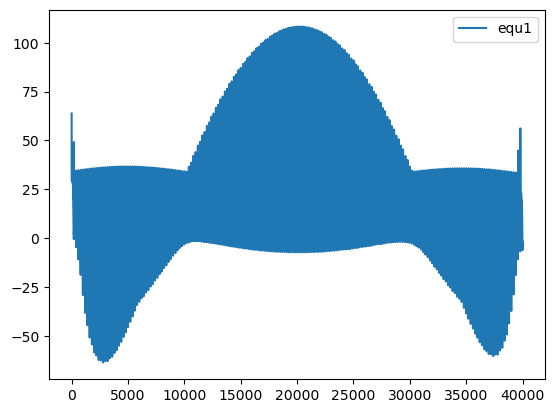

In [8]:
#equ1=manual_diff_r(sigma_rr_fem,r_f,num)+manual_diff_z(sigma_zr_fem,z_f,num)+(sigma_rr_fem-sigma_theta_fem)/r_f
equ1=manual_diff_r(sigma_rr,r_f,num)+manual_diff_z(sigma_zr,z_f,num)+(sigma_rr-sigma_theta)/r_f
#equ1=(sigma_rr_fem-sigma_theta_fem)/r_f
#equ1=manual_diff_r(sigma_zr,r_f,num)
#equ1=manual_diff_r(sigma_rr_norm,r_norm,num)/(r2-r1)+manual_diff_z(sigma_zr_norm,z_norm,num)/h1+(sigma_rr_norm-sigma_theta_nrom)/((r2-r1)*r_norm+r1)
print(np.mean(equ1))
print(list(equ1))
plt.plot(equ1,label='equ1')
plt.legend()
plt.show()
# with open("output.txt", "w") as file:
#     file.write("equ1: " + str(list(equ1)))

2.724105328117261e-05


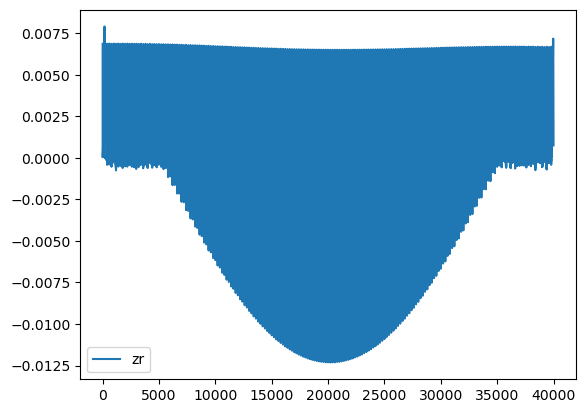

In [31]:
sigma_rr_fem=fem['solid.sr'].values
sigma_theta_fem=fem['solid.sphi'].values
sigma_zz_fem=fem['solid.sz'].values
sigma_zr_fem=fem['solid.srz'].values
print(np.mean(sigma_zr_fem-sigma_zr))
#plt.plot(sigma_rr_fem-sigma_rr,label='r')
#plt.plot(sigma_theta_fem-sigma_theta,label='theta')
#plt.plot(sigma_zz_fem-sigma_zz,label='z')
plt.plot(sigma_zr_fem-sigma_zr,label='zr')
plt.legend()
plt.show()

-0.004348702608089985
0.00036060562774284366


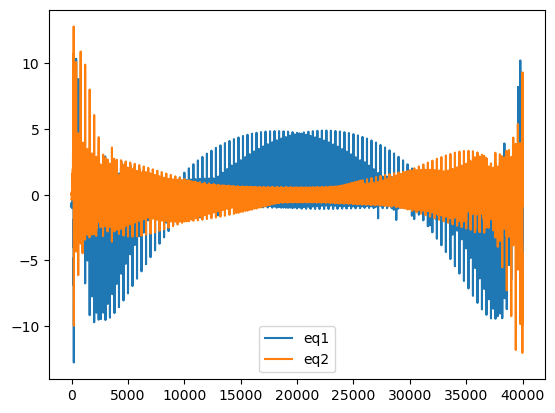

In [17]:
d_sigma_r_dr=manual_diff_r(sigma_rr_fem,r_f)
d_sigma_zr_dz=manual_diff_z(sigma_zr_fem,z_f)
d_sigma_z_dz=manual_diff_z(sigma_zz_fem,z_f)
d_sigma_zr_dr=manual_diff_r(sigma_zr_fem,r_f)
eq1=d_sigma_r_dr+d_sigma_zr_dz+(sigma_rr_fem-sigma_theta_fem)/r_f
eq2=d_sigma_z_dz+d_sigma_zr_dr+sigma_zr_fem/r_f
print(np.mean(eq1))
print(np.mean(eq2))
plt.plot(eq1,label='eq1')
plt.plot(eq2,label='eq2')
plt.legend()
plt.show()

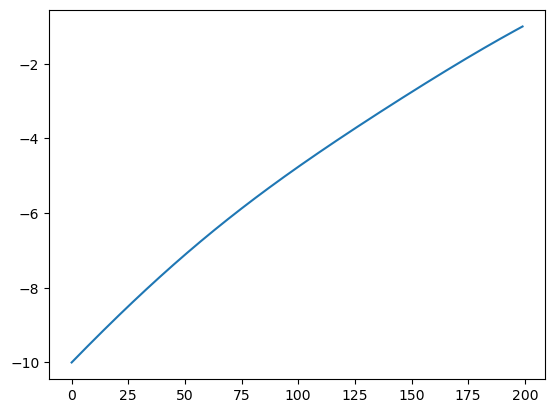

In [10]:
sigma_rr_fem=torch.tensor(fem['solid.sr']).reshape(200,200)
t=sigma_rr_fem[:,1].detach().numpy()
plt.plot(t)